In [1]:
#
import numpy as np
import os, sys
import matplotlib.pyplot as plt

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/omarlibs/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg
from cuts import getGeoCuts, get_bgs, flux_to_mag
from QA import getStats, flow

import healpy as hp
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as units
import fitsio

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
Nranfiles = 3
patch = None #[174., 186., -3., 2.]
reg = 'desi' #'south', 'north', 'decals', 'des', 'svfields'
dr = 'dr8'
version = '2.0'
if dr == 'dr9d': Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20
dec_resol_ns = 32.375

# for healpy
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

## catalogue

In [3]:
#
#cat =  get_sweep_whole(patch=patch, dr='dr8', rlimit=21.0, maskbitsource=False, bgsbits=True, opt='1', version=version) # catalogue
desit_dr8_n = '/global/cscratch1/sd/qmxp55/desitarget_output/targets-dr8.0-north/targets/main/resolve/bright/targets-dr8-hp-X.fits'
desit_dr8_s = '/global/cscratch1/sd/qmxp55/desitarget_output/targets-dr8.0-south/targets/main/resolve/bright/targets-dr8-hp-X.fits'
catn = fitsio.read(desit_dr8_n)
cats = fitsio.read(desit_dr8_s)
cat = np.concatenate((catn, cats))

hppix_cat = hp.ang2pix(nside,(90.-cat['DEC'])*np.pi/180.,cat['RA']*np.pi/180.,nest=True) # catalogue hp pixels array
print('healpix cat DONE...')
c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
galb = c.galactic.b.value # galb coordinate
print('GAL b DONE...')

catinregs = {}
#regs = ['des', 'decals', 'north', 'desi', 'south', 'svfields']
regs = ['des', 'decals', 'north', 'desi', 'south', 'svfields']
for i in regs:
    reg_ = get_reg(reg=i, hppix=hppix_cat)
    catinregs[i] = reg_
    print(i, 'DONE...')
    


des DONE...
decals DONE...
north DONE...
desi DONE...
south DONE...
svfields DONE...


In [4]:
catinreg = (catinregs['desi']) & (catinregs[reg])
catindesi = catinregs['desi']

### randoms

In [5]:
randoms = get_random(N=Nranfiles, sweepsize=None, dr=dr) # randoms

indesiranfile = '/global/cscratch1/sd/qmxp55/random_%s_indesi_N%s.npy' %(dr, Nranfiles)
is_indesiranfile = os.path.isfile(indesiranfile)
if is_indesiranfile: 
    ranindesi = np.load(indesiranfile)
else: 
    ranindesi = get_isdesi(randoms['RA'],randoms['DEC']) # True is is in desi footprint
    np.save(indesiranfile, ranindesi)
    
hppixranfile = '/global/cscratch1/sd/qmxp55/hppix_%s_random_N%s.npy' %(dr, Nranfiles)
is_hppixranfile = os.path.isfile(hppixranfile)
if is_hppixranfile: 
    hppix_ran = np.load(hppixranfile)
else: 
    hppix_ran = hp.ang2pix(nside,(90.-np.array(randoms['DEC']))*np.pi/180.,np.array(randoms['RA'])*np.pi/180.,nest=nest) # randoms hp pixels array
    np.save(hppixranfile, hppix_ran)

RANDOM file already exist at:/global/cscratch1/sd/qmxp55/dr8_random_N3.npy
Total run time: 0.001031 sec
Weight of /global/cscratch1/sd/qmxp55/dr8_random_N3.npy catalogue: 6.82 GB


In [6]:
# get regions for randoms. This is a one time thing for every release.

raninreg = '/global/cscratch1/sd/qmxp55/inREGIONS_randoms_%s_N%s.npy' %(dr, Nranfiles)
is_raninreg = os.path.isfile(raninreg)
if is_raninreg:
    raninregs = np.load(raninreg)
else:
    raninregs = {}
    regs = ['des', 'decals', 'north', 'desi', 'south', 'svfields']
    for i in regs:
        reg_ = get_reg(reg=i, hppix=hppix_ran)
        raninregs[i] = reg_
        print(i, 'DONE...')

    # save region info as npy file
    from astropy.table import Table
    tabreg = Table()

    for key in raninregs.keys():
        tabreg[key] = raninregs[key]
    
    # save astropy table as npy file
    np.save(raninreg, tabreg)
    
raninreg = (raninregs['desi']) & (raninregs[reg])


In [7]:
#
def keepPatch(patch, catalog):
    
    mask = np.ones_like(catalog['RA'], dtype='?')
    mask &= np.logical_and(catalog['RA'] >= patch[0], catalog['RA'] <= patch[1])
    mask &= np.logical_and(catalog['DEC'] >= patch[2], catalog['DEC'] <= patch[3])
    
    return mask


if patch is not None:
    
    keep = keepPatch(patch=patch, catalog=randoms)
    randoms = randoms[keep]
    ranindesi = ranindesi[keep]
    hppix_ran = hppix_ran[keep]
    raninreg = raninreg[keep]
    

In [8]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(randoms, randoms=True)

In [9]:
#get rid of BGS WISE
bgsf = (cat['BGS_TARGET'] & 2**(0)) != 0
bgsb = (cat['BGS_TARGET'] & 2**(1)) != 0
bgs = (bgsf) | (bgsb)

print(len(cat), np.sum(bgsf), np.sum(bgsb), np.sum(bgs))

27402858 10874580 15829519 26704099


## Target density in hp-pixels

In [10]:
#dic with default BGS selection and in DESI footprint
hpdict = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs']) & (raninreg)),
                          maskcat=((catinreg) & (bgs)), 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=catindesi, 
                                namesels={'any':-1, 'bright':1, 'faint':0}, galb=galb, log=True, survey='main')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  304987125
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_any_all = 1417 /deg2
meandens_any_des = 1430 /deg2
meandens_any_decals = 1425 /deg2
meandens_any_north = 1397 /deg2
meandens_any_south = 1426 /deg2
meandens_any_svfields = 1418 /deg2
meandens_any_svfields_n = 1369 /deg2
meandens_any_svfields_s = 1437 /deg2
meandens_bright_all = 840 /deg2
meandens_bright_des = 850 /deg2
meandens_bright_decals = 847 /deg2
meandens_bright_north = 824 /deg2
meandens_bright_south = 847 /deg2
meandens_bright_svfields = 833 /deg2
meandens_bright_svfields_n = 795 /deg2
meandens_bright_svfields_s = 848 /deg2
meandens_faint_all = 577 /deg2
meandens_faint_des = 580 /deg2

In [11]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

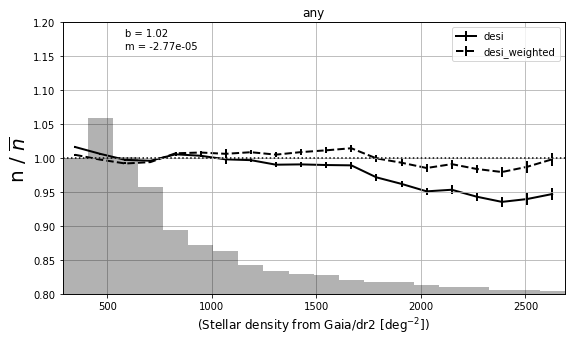

In [23]:
# get b and m coefficients for stellar density weights

isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
namesel = 'any'
syst='stardens'

fig    = plt.figure(figsize=(9,5))
gs     = gridspec.GridSpec(1,1,hspace=0.30,wspace=0.25)
    
plot_sysdens(hpdicttmp=hpdict, namesel=namesel, regs=[reg], syst=syst, mainreg=isdesi, xlim=None, n=0, nx=20, 
             clip=True, denslims=False, ylab=True, weights=True, fig=fig, gs=gs, label=True)

fig.savefig('syst_w_weights_%s_%s_%s_%s.png' %(syst, dr, reg, namesel), bbox_inches = 'tight', pad_inches = 0)


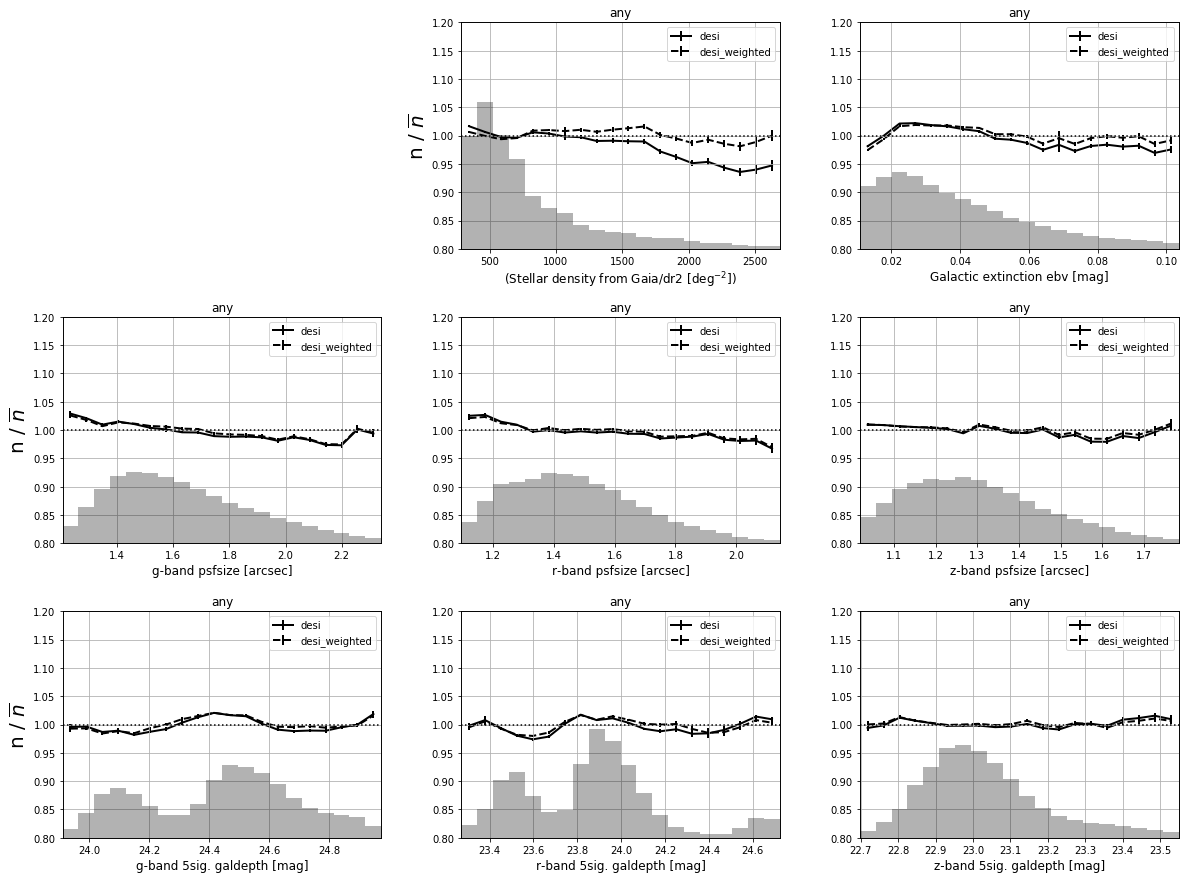

In [22]:
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']

fig    = plt.figure(figsize=(20,15))
gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
ws = 1./((-2.77*10**(-5))*hpdict['stardens'] + 1.02)
namesel = 'any'
    
for i in range(9):
    
    if i == 0: continue
    if (i%3==0) or (i==1): ylab=True
    else: ylab = False
        
    plot_sysdens(hpdicttmp=hpdict, namesel=namesel, regs=[reg], syst=systs[i-1], mainreg=isdesi, xlim=None, n=i, nx=20, 
             clip=True, denslims=False, ylab=ylab, weights=True, fig=fig, gs=gs, label=True, ws=ws)
    
fig.savefig('syst_w_weights_%s_%s_%s.png' %(dr, reg, namesel), bbox_inches = 'tight', pad_inches = 0)


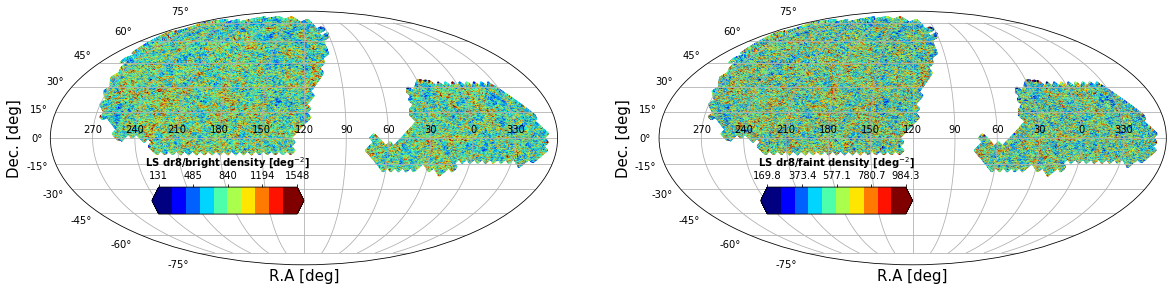

In [20]:
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(1,2)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

if reg == 'desi': reg_ = 'all'
else: reg_ = reg
    
mollweide(hpdict=hpdict, namesel='bright', reg=reg_, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None)
mollweide(hpdict=hpdict, namesel='faint', reg=reg_, projection=projection, n=1, org=org, cm=cm, fig=fig, gs=gs, cval=None)

In [24]:
# match associated target density for each object
import pandas as pd

s = pd.Series(hppix_cat)
d = s.groupby(s).groups

DENS = np.zeros_like(cat['RA'])
WS = np.zeros_like(cat['RA'])
hpdens = (hpdict['south_nany'] + hpdict['north_nany'] ) / (pixarea * hpdict['bgsfracarea'])
print(len(hpdens), len(ws))
#
for npixid, catids in zip(d.keys(), d.values()):
    DENS[catids] = hpdens[npixid]
    WS[catids] = ws[npixid]
    

786432 786432


In [25]:
cols = ['RA', 'DEC', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FIBERFLUX_R', 'MW_TRANSMISSION_R', 
                'MW_TRANSMISSION_G', 'MW_TRANSMISSION_Z','MASKBITS', 'REF_CAT', 'REF_ID', 
                    'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE', 'FRACFLUX_G', 
                        'FRACFLUX_R', 'FRACFLUX_Z', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z',
                             'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'MORPHTYPE', 'FLUX_IVAR_R', 'FLUX_IVAR_G',
                                   'FLUX_IVAR_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z']

In [33]:
#
from astropy.table import Table

tab = Table()
for col in cols:
    if (col[:4] == 'FLUX') & (col[:9] != 'FLUX_IVAR'): tab[col[-1:]+'MAG'] = flux_to_mag(cat['FLUX_'+col[-1:]]/cat['MW_TRANSMISSION_'+col[-1:]])
    elif col[:2] == 'MW': continue
    elif col == 'FIBERFLUX_R': tab['RFIBERMAG'] = flux_to_mag(cat[col]/cat['MW_TRANSMISSION_R'])
    elif col == 'GAIA_PHOT_G_MEAN_MAG': tab['G'] = cat[col]
    elif col == 'GAIA_ASTROMETRIC_EXCESS_NOISE': tab['AEN'] = cat[col]
    else: tab[col] = cat[col]
        
for key in catinregs.keys():
    tab[key] = catinregs[key]
    
tab['FLUX_R'] = cat['FLUX_R']
tab['DENS'] = DENS
tab['WS'] = WS
tab['bgs'] = bgs
tab['bgs_faint'] = bgsf
tab['bgs_bright'] = bgsb
tab['galb'] = galb

# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/pauline/BGS_main_dr8_pauline_2.0'
np.save(dest, tab)


In [35]:
c_ran = SkyCoord(randoms['RA']*units.degree,randoms['DEC']*units.degree, frame='icrs')
galb_ran = c_ran.galactic.b.value # galb coordinate
print('GAL b DONE...')

GAL b DONE...


In [36]:
#
tabran = Table()

mask = (rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])

tabran['RA'], tabran['DEC'] = randoms['RA'][mask], randoms['DEC'][mask]
for key in raninregs.dtype.names:
    tabran[key] = raninregs[key][mask]

tabran['galb'] = galb_ran[mask]
    
# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/pauline/randoms_dr8_N3_pauline_2.0'
np.save(dest, tabran)

# Sanity checks with some skyplots...

Text(0, 0.5, 'Dec.')

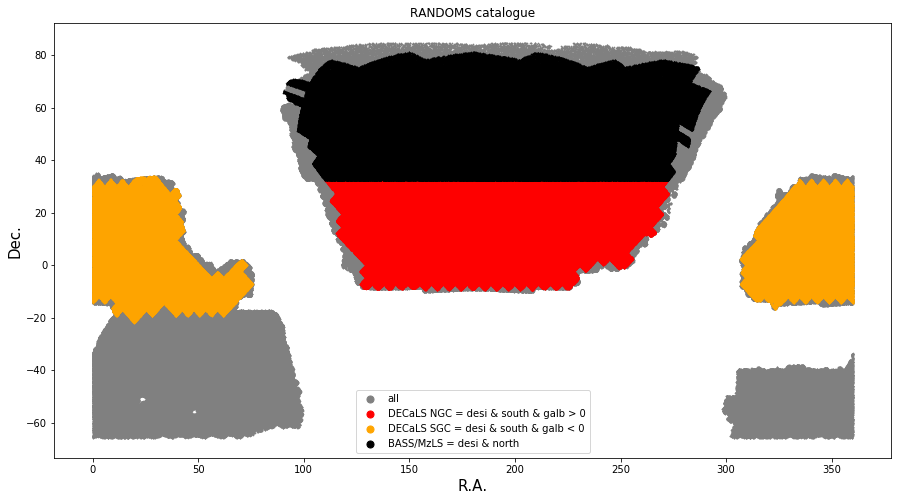

In [40]:
plt.figure(figsize=(15,8))

maskn = (tabran['north']) & (tabran['desi'])
masks_n = (tabran['south']) & (tabran['desi']) & (tabran['galb'] > 0)
masks_s = (tabran['south']) & (tabran['desi']) & (tabran['galb'] < 0)
N = 200

plt.scatter(tabran['RA'][::N], tabran['DEC'][::N], s=0.5, c='gray', label='all')
plt.scatter(tabran['RA'][masks_n][::N], tabran['DEC'][masks_n][::N], s=0.5, c='r', label='DECaLS NGC = desi & south & galb > 0')
plt.scatter(tabran['RA'][masks_s][::N], tabran['DEC'][masks_s][::N], s=0.5, c='orange', label='DECaLS SGC = desi & south & galb < 0')
plt.scatter(tabran['RA'][maskn][::N], tabran['DEC'][maskn][::N], s=0.5, c='k', label='BASS/MzLS = desi & north')
#plt.axhline(dec_resol_ns, lw=2, c='b', ls='--')

plt.title('RANDOMS catalogue')

lgnd = plt.legend()
[handle.set_sizes([50]) for handle in lgnd.legendHandles]

plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)


Text(0, 0.5, 'Dec.')

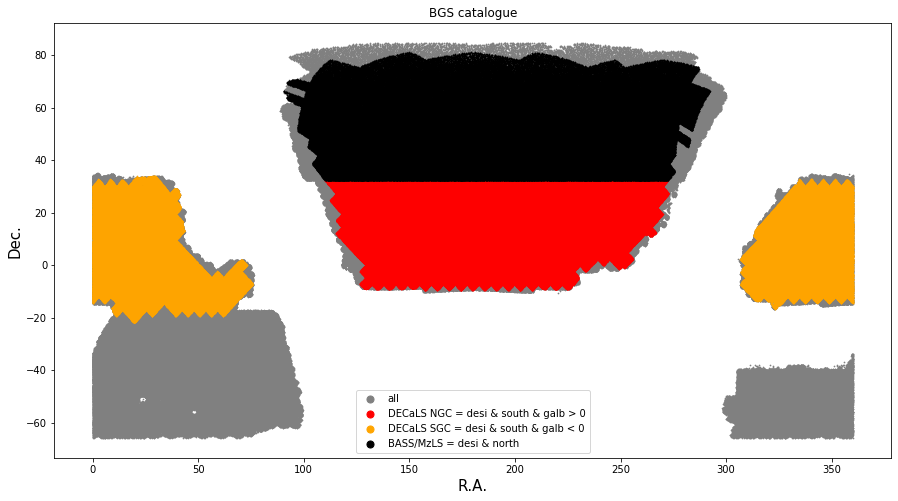

In [34]:
plt.figure(figsize=(15,8))

#plt.scatter(tab['RA'][::1000], tab['DEC'][::1000])
maskn = (tab['north']) & (tab['desi'])
masks_n = (tab['south']) & (tab['desi']) & (tab['galb'] > 0)
masks_s = (tab['south']) & (tab['desi']) & (tab['galb'] < 0)
#plt.scatter(tab['RA'][tab['north']][::1000], tab['DEC'][tab['north']][::1000], label='north')
#plt.scatter(tab['RA'][tab['WS']>0][::20], tab['DEC'][tab['WS']>0][::20], s=0.5, label='WS > 0')
plt.scatter(tab['RA'][::30], tab['DEC'][::30], s=0.5, c='gray', label='all')
plt.scatter(tab['RA'][masks_n][::30], tab['DEC'][masks_n][::30], s=0.5, c='r', label='DECaLS NGC = desi & south & galb > 0')
plt.scatter(tab['RA'][masks_s][::30], tab['DEC'][masks_s][::30], s=0.5, c='orange', label='DECaLS SGC = desi & south & galb < 0')
plt.scatter(tab['RA'][maskn][::30], tab['DEC'][maskn][::30], s=0.5, c='k', label='BASS/MzLS = desi & north')
#plt.axhline(dec_resol_ns, lw=2, c='b', ls='--')

plt.title('BGS catalogue')

lgnd = plt.legend()
[handle.set_sizes([50]) for handle in lgnd.legendHandles]

plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)


In [ ]:
stars = np.load('/global/cscratch1/sd/qmxp55/pauline/stars_GAIA_TYCHO_13.npy')

In [ ]:
stars.dtype.names

In [ ]:
plt.figure(figsize=(15,8))

#plt.scatter(tab['RA'][::1000], tab['DEC'][::1000])
mask = (stars['issouth']) & (stars['isdesi'])
#plt.scatter(tab['RA'][tab['north']][::1000], tab['DEC'][tab['north']][::1000], label='north')
plt.scatter(stars['RA'][::5], stars['DEC'][::5], s=0.5, label='all')
#plt.scatter(stars['RA'][stars['issouth']][::10], stars['DEC'][stars['issouth']][::10], s=0.5, label='south')
plt.scatter(stars['RA'][mask][::5], stars['DEC'][mask][::5], s=0.5, label='desi & south')

plt.title('STARS catalogue')

plt.legend()
plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)


In [ ]:
plt.figure(figsize=(10,6))
plt.hist(stars['MAG'], 30)
plt.show()

In [ ]:
set(stars['REF_CAT'])